# Vehicle Re-Id
* **dataset**: veri-776
* **model**: Cnn allenata con Triplet Loss

## 1. Download datasets

In [ ]:
# Monto il mio google drive (una volta montanto il contenuto di google drive sarà accessibile nella directory `/content/drive/My Drive`)
from google.colab import drive
!mkdir -p drive/
drive.mount("/content/drive")

In [2]:
# Indoviduo il path del dataset
dataset_path = "/content/drive/MyDrive/datasets/VeRi.zip"

In [3]:
# Creo la cartella `data`
!mkdir -p data/

In [4]:
# Copio il file nel Workspace
!cp "/content/drive/MyDrive/datasets/VeRi.zip" /content/

In [5]:
# Controllo il tipo di file scaricato
!file VeRi.zip

VeRi.zip: Zip archive data, at least v1.0 to extract, compression method=store


In [6]:
# Decomprimo il file zip
!unzip -q /content/VeRi.zip -d data

## 2. Organizzazione Dataset

Parsing del file XML

Estraggo dai file XML (`train_label.xml` e `test_label.xml`) le informazioni rilevanti e le memorizzo in un DataFrame (Pandas).

I campi rilevanti nei file sono: 
* Nome immagine
* Vechile ID
* Camera ID
* Color ID
* Type ID

In [2]:
import xml.etree.ElementTree as ET
import pandas as pd

def parse_labels(label_path):
    # Lista per memorizzare i dati
    data = []

    # Aprire il file con la codifica esplicita
    with open(label_path, "r", encoding="ascii", errors="ignore") as f:
      content = f.read() # Leggi il contenuto ignorando gli errori

      try:
        tree = ET.ElementTree(ET.fromstring(content))  # Parso direttamente il contenuto
        root = tree.getroot()  # Ottieni il nodo radice
        # Iterare attraverso i nodi Item
        for item in root.find("Items").findall("Item"):
          image_name = item.get("imageName")
          vehicle_id = item.get("vehicleID")
          camera_id = item.get("cameraID")
          color_id = item.get("colorID")
          type_id = item.get("typeID")

          # Aggiungere i dati alla lista
          data.append({
            "image_name": image_name,
            "vehicle_id": int(vehicle_id),
            "camera_id": camera_id,
            "color_id": int(color_id),
            "type_id": int(type_id)
          })
      except ET.ParseError as e:
        print(f"Errore di parsing: {e}")
        return {}

    return pd.DataFrame(data)

# Percorso al file XML
train_label_path = "./data/VeRi/train_label.xml"
test_label_path = "./data/VeRi/test_label.xml"

# Creo un dataframe per le immagini di train e test
train_labels_df = parse_labels(train_label_path)
test_labels_df = parse_labels(test_label_path)

# Recupero le dimensioni dei dataset (righe e colonne)
train_df_rows, train_df_cols = train_labels_df.shape
test_df_rows, test_df_cols = test_labels_df.shape

print(f"train dataframe: righe: {train_df_rows}, colonne: {train_df_cols}")
print(f"test dataframe: righe: {test_df_rows}, colonne: {test_df_cols}")

train dataframe: righe: 37746, colonne: 5
test dataframe: righe: 11579, colonne: 5


In [ ]:
# Controllo i primi elementi per confermare che le colonne siano riempite correttamente
print(train_labels_df.head())
print(test_labels_df.head())

                 image_name  vehicle_id camera_id  color_id  type_id
0  0001_c001_00016450_0.jpg           1      c001         1        4
1  0001_c001_00016460_0.jpg           1      c001         1        4
2  0001_c001_00016470_0.jpg           1      c001         1        4
3  0001_c001_00016480_0.jpg           1      c001         1        4
4  0001_c001_00016490_0.jpg           1      c001         1        4
                 image_name  vehicle_id camera_id  color_id  type_id
0  0002_c002_00030600_0.jpg           2      c002         1        4
1  0002_c002_00030605_1.jpg           2      c002         1        4
2  0002_c002_00030615_1.jpg           2      c002         1        4
3  0002_c002_00030625_1.jpg           2      c002         1        4
4  0002_c002_00030640_0.jpg           2      c002         1        4


In [ ]:
# Controllo che non ci siano valori nulli nei dataframe (stampa quanti NULL ci sono)
print(train_labels_df.isnull().sum())
print(test_labels_df.isnull().sum())

image_name    0
vehicle_id    0
camera_id     0
color_id      0
type_id       0
dtype: int64
image_name    0
vehicle_id    0
camera_id     0
color_id      0
type_id       0
dtype: int64


## 3. Creazione e gestione delle Triple per l'allenamento della rete
Devo creare triple di immagini:
* **Anchor**: Immagine del veicolo da prendere come punto di riferimento.
* **Positiva**: Altra immagine del veicolo di anchor.
* **Negativa**: Immagine diversa dal veicolo di anchor.

Le triple generate hanno un formato (anchor, positive, negative).

Per la creazione utilizzo un approccio chiamato `Random Triplet` che scegli le tre immagini in maniera casuale tra quelle disponibili nel dataset,
facendo sempre attenzione a rispettare i vincoli espressi in precedenza tra i veicoli.

Genero 800.000 triple per il train (2.400.000 immagini) e 200.000 triple per il test (600.000 immagini), per un totale di 3.000.000 immagini utilizzate nelle triple.
Il dataset è diviso in 80% train e 20% test in termini di triple.

In [6]:
import random

def create_triplets(dataframe, num_triplets):
    """
    Genera triplette (anchor, positive, negative) da un dataframe di immagini.

    Args:
        dataframe (pd.DataFrame): Contiene colonne ['image_name', 'vehicle_id'].
        num_triplets (int): Numero di triplette da generare.

    Returns:
        List[Tuple]: Lista di tuple (anchor, positive, negative).
    """
    data_by_id = dataframe.groupby("vehicle_id")
    unique_ids = dataframe["vehicle_id"].unique()

    triplets = []

    for _ in range(num_triplets):
        # Scegli un vehicle_id casuale per l'ancora e il positivo
        anchor_vehicle_id = random.choice(unique_ids)
        anchor_images = data_by_id.get_group(anchor_vehicle_id)["image_name"].values

        # Scegli due immagini diverse per l'ancora e il positivo
        anchor, positive = random.sample(list(anchor_images), 2)

        # Scegli un vehicle_id diverso per il negativo
        negative_vehicle_id = random.choice([vid for vid in unique_ids if vid != anchor_vehicle_id])
        negative_images = data_by_id.get_group(negative_vehicle_id)["image_name"].values

        # Scegli un'immagine casuale per il negativo
        negative = random.choice(negative_images)

        triplets.append((anchor, positive, negative))

    return triplets

# Genera triplette per train e test
train_triplets = create_triplets(train_labels_df, num_triplets=800000)
test_triplets = create_triplets(test_labels_df, num_triplets=200000)

print(f"Numero di triple del train: {len(train_triplets)}")
print(f"Numero di triple del test: {len(test_triplets)}")

Numero di triple del train: 800000
Numero di triple del test: 200000


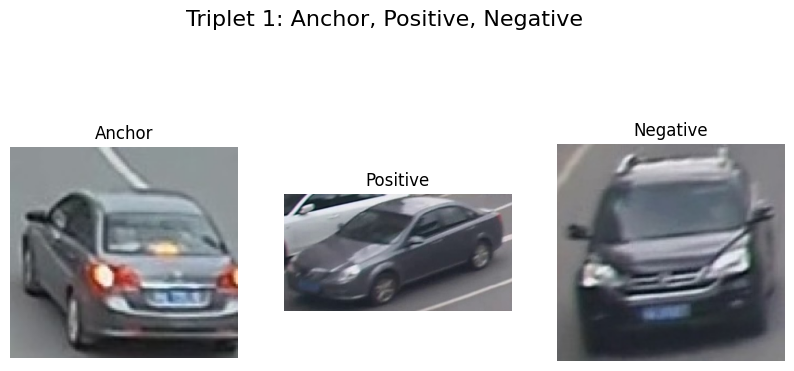

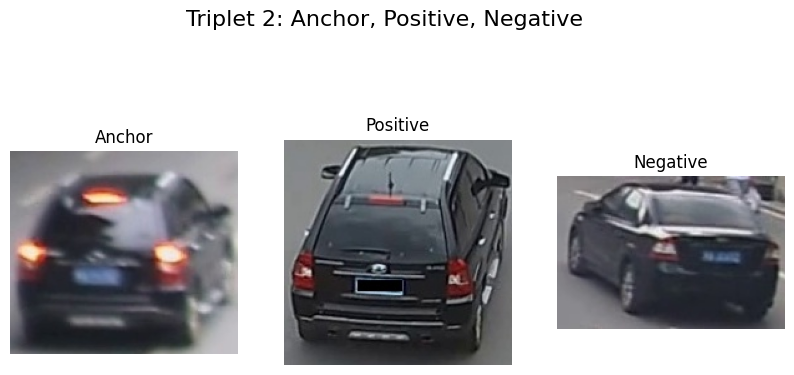

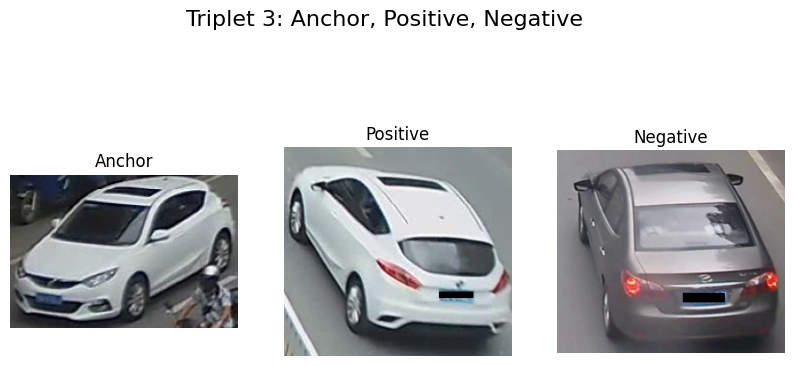

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_triplets(triplets, root_dir, num_triplets=3):
    """
    Mostra le immagini delle triplette (anchor, positive, negative).

    Args:
        triplets (List[Tuple]): Lista di triplette (anchor, positive, negative).
        root_dir (str): Directory principale delle immagini.
        num_triplets (int): Numero di triplette da visualizzare.
    """
    for i in range(num_triplets):
        anchor, positive, negative = triplets[i]

        # Carica le immagini
        anchor_img = Image.open(os.path.join(root_dir, anchor)).convert("RGB")
        positive_img = Image.open(os.path.join(root_dir, positive)).convert("RGB")
        negative_img = Image.open(os.path.join(root_dir, negative)).convert("RGB")

        # Crea una figura con 3 colonne (anchor, positive, negative)
        fig, axes = plt.subplots(1, 3, figsize=(10, 5))
        fig.suptitle(f"Triplet {i+1}: Anchor, Positive, Negative", fontsize=16)

        # Mostra l'ancora
        axes[0].imshow(anchor_img)
        axes[0].set_title("Anchor")
        axes[0].axis("off")

        # Mostra il positivo
        axes[1].imshow(positive_img)
        axes[1].set_title("Positive")
        axes[1].axis("off")

        # Mostra il negativo
        axes[2].imshow(negative_img)
        axes[2].set_title("Negative")
        axes[2].axis("off")

        plt.show()

# Percorso della directory delle immagini
root_dir = "./data/VeRi/image_train"

show_triplets(train_triplets, root_dir, num_triplets=3)

In [8]:
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms

class TripletDataset(Dataset):
    def __init__(self, triplets, image_dir, transform=None):
        """
        Dataset per le triplette (anchor, positive, negative).

        Args:
            triplets (List[Tuple]): Lista di triplette (anchor, positive, negative).
            image_dir (str): Directory principale delle immagini.
            transform (callable, optional): Trasformazioni da applicare alle immagini.
        """
        self.triplets = triplets
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor, positive, negative = self.triplets[idx]

        # Carica le immagini
        anchor_img = Image.open(os.path.join(self.image_dir, anchor)).convert("RGB")
        positive_img = Image.open(os.path.join(self.image_dir, positive)).convert("RGB")
        negative_img = Image.open(os.path.join(self.image_dir, negative)).convert("RGB")

        # Applica le trasformazioni
        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img

In [9]:
from torchvision import transforms

# Trasformazioni per l'allenamento
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),  # Flip orizzontale con probabilità 0.5
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Variazione di colore
    transforms.RandomRotation(degrees=15),  # Rotazione casuale fino a 15 gradi
    transforms.ToTensor(),  # Converte l'immagine in un tensore
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizzazione
])
    

# Trasformazioni per il test
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  # Converte l'immagine in tensore
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizzazione
])

Creo i `DataLoader` del train e del test:

Il `DataLoader` è una classe che facilita il caricamento dei dati da un dataset suddividendoli in mini-batch (in questo caso batch_size=256) e gestendo le operazioni come lo shiffling (il rimescolamento dei dati ad ogni epoca per migliorare la generalizzazione del modello).

Prima della creazione dei DataLoader vengono applicati anche operazioni di preprocessing (`transform`) per il `Data Augmentation`, tecniche come la rotazione che possono essere applicate alle immagini per aumentare la varietà dei dati.

In [10]:
from torch.utils.data import DataLoader

# Configura il DataLoader
train_dataset = TripletDataset(train_triplets, image_dir="./data/VeRi/image_train", transform=train_transform)
test_dataset = TripletDataset(test_triplets, image_dir="./data/VeRi/image_test", transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

## 4. Definizione del modello
Il modello `LightCnnNetwork` è una rete convoluzionale (CNN) progettata per essere leggera, adatta a compiti come il confronto tra immagini, questa CNN estrae rappresentazioni compatte, `embedding` da un'immagine.
Struttura:
1. *Estrattore di Caratteristiche*:
* **Conv2D**: Filtri convoluzionali per estrarre caratteristiche spaziali.
* **ReLU**: Funzione di attivazione non lineare.
* **MaxPool2D**: Riduce le dimensioni spaziali dimezzandole.
* **AdaptiveAvgPool2D**: Riduce ulteriormente la rappresentazione spaziale a un vettore di dimensione fissa (64, 1, 1).
* **Flatten**: Converte il risultato finale in un vettore piatto di dimensione (batch_size, 64).
2. *Proiezione nello spazio degli Embedding*:
    
    Questo blocco prende il vettore di caratteristiche prodotto dall'estrattore (feature_extractor) e lo trasforma in un embedding, cioè una rappresentazione compatta e discriminativa dell'immagine.
* **Linear**(64, embedding_dim): strato di trasformazione lineare che mappa il vettore in input(dimensione 64) in uno spazio di dimensione `embedding_dim` con lo scopo di mappare il vettore in uno spazio dove le relazioni di similarità siano più evidenti.
* **ReLU**: Funzione di attivazione non lineare.
* **Linear**: altro strato lineare che agisce come una raffinazione o trasformazione finale dell'embedding.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LightCnnNetwork(nn.Module):
    def __init__(self, embedding_dim=64):
        super(LightCnnNetwork, self).__init__()

        # Feature extractor semplice e leggero
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # (C=16, H, W)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (C=16, H/2, W/2)
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (C=32, H/2, W/2)
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # (C=32, H/4, W/4)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # (C=64, H/4, W/4)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),  # Output: (64, 1, 1)
            nn.Flatten()  # Output: (batch_size, 64)
        )

        # Proiezione nello spazio degli embedding
        self.fc = nn.Sequential(
            nn.Linear(64, embedding_dim),
            nn.ReLU(),
            nn.Linear(embedding_dim, embedding_dim)
        )

    def forward_once(self, x):
        """
        Esegue una forward pass per una singola immagine.
        """
        x = self.feature_extractor(x)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        """
        Forward pass per due immagini.
        """
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


## 5. Train & Eval 
 * **Fase di Allenamento** (train): Allena il modello con la Triplet Loss sulle triple di veicoli generate precedentemente.
 * **Fase di Valutazione** (eval): Valuta quanto bene il modello ha imparato dalla fase di allenamento. 

In [12]:
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch

def train_model(model, train_loader, test_loader, num_epochs):
    """
    Addestra il modello utilizzando la Triplet Loss e salva le metriche.

    Args:
        model (nn.Module): Modello da addestrare.
        train_loader (DataLoader): DataLoader per il training.
        test_loader (DataLoader): DataLoader per il test.
        num_epochs (int): Numero di epoche.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Definisci la Triplet Loss
    criterion = nn.TripletMarginLoss(margin=0.5)

    # Definisci l'ottimizzatore
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Liste per salvare le metriche
    train_losses = []
    eval_losses = []
    eval_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        # Barra di avanzamento per il training
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for anchor, positive, negative in train_loop:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            # Azzera i gradienti
            optimizer.zero_grad()

            # Forward pass
            anchor_embedding = model.forward_once(anchor)
            positive_embedding = model.forward_once(positive)
            negative_embedding = model.forward_once(negative)

            # Calcola la Triplet Loss
            loss = criterion(anchor_embedding, positive_embedding, negative_embedding)

            # Backward pass e ottimizzazione
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Aggiorna la descrizione della barra di avanzamento
            train_loop.set_postfix(train_loss=loss.item())

        # Salva il loss del training per questa epoca
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # Valutazione sul test set
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        # Barra di avanzamento per la valutazione
        test_loop = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Eval]", leave=False)
        with torch.no_grad():
            for anchor, positive, negative in test_loop:
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

                # Forward pass
                anchor_embedding = model.forward_once(anchor)
                positive_embedding = model.forward_once(positive)
                negative_embedding = model.forward_once(negative)

                # Calcola la Triplet Loss
                loss = criterion(anchor_embedding, positive_embedding, negative_embedding)
                test_loss += loss.item()

                # Calcola l'accuratezza (esempio: distanza tra anchor e positive < distanza tra anchor e negative)
                positive_distance = torch.norm(anchor_embedding - positive_embedding, dim=1)
                negative_distance = torch.norm(anchor_embedding - negative_embedding, dim=1)
                correct += (positive_distance < negative_distance).sum().item()
                total += anchor.size(0)

                # Aggiorna la descrizione della barra di avanzamento
                test_loop.set_postfix(eval_loss=loss.item())

        # Salva il loss di valutazione e l'accuratezza per questa epoca
        epoch_eval_loss = test_loss / len(test_loader)
        epoch_eval_accuracy = correct / total

        eval_losses.append(epoch_eval_loss)
        eval_accuracies.append(epoch_eval_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Eval Loss: {epoch_eval_loss:.4f}, "
              f"Eval Accuracy: {epoch_eval_accuracy:.4f}")

    return train_losses, eval_losses, eval_accuracies

In [13]:
model = LightCnnNetwork(embedding_dim=64)
train_losses, eval_losses, eval_accuracies = train_model(model, train_loader, test_loader, 20)

Epoch [1/20], Train Loss: 0.1569, Eval Loss: 0.1103, Eval Accuracy: 0.9050


Epoch [2/20], Train Loss: 0.0981, Eval Loss: 0.0896, Eval Accuracy: 0.9233


Epoch [3/20], Train Loss: 0.0785, Eval Loss: 0.0800, Eval Accuracy: 0.9313


Epoch [4/20], Train Loss: 0.0666, Eval Loss: 0.0727, Eval Accuracy: 0.9382


Epoch [5/20], Train Loss: 0.0594, Eval Loss: 0.0657, Eval Accuracy: 0.9444


Epoch [6/20], Train Loss: 0.0544, Eval Loss: 0.0691, Eval Accuracy: 0.9416


Epoch [7/20], Train Loss: 0.0507, Eval Loss: 0.0652, Eval Accuracy: 0.9452


Epoch [8/20], Train Loss: 0.0479, Eval Loss: 0.0613, Eval Accuracy: 0.9487


Epoch [9/20], Train Loss: 0.0455, Eval Loss: 0.0592, Eval Accuracy: 0.9503


Epoch [10/20], Train Loss: 0.0433, Eval Loss: 0.0622, Eval Accuracy: 0.9480


Epoch [11/20], Train Loss: 0.0416, Eval Loss: 0.0574, Eval Accuracy: 0.9522


Epoch [12/20], Train Loss: 0.0400, Eval Loss: 0.0559, Eval Accuracy: 0.9536


Epoch [13/20], Train Loss: 0.0388, Eval Loss: 0.0550, Eval Accuracy: 0.9544


Epoch [14/20], Train Loss: 0.0373, Eval Loss: 0.0528, Eval Accuracy: 0.9566


Epoch [15/20], Train Loss: 0.0364, Eval Loss: 0.0534, Eval Accuracy: 0.9556


Epoch [16/20], Train Loss: 0.0355, Eval Loss: 0.0515, Eval Accuracy: 0.9573


Epoch [17/20], Train Loss: 0.0346, Eval Loss: 0.0511, Eval Accuracy: 0.9579


Epoch [18/20], Train Loss: 0.0335, Eval Loss: 0.0546, Eval Accuracy: 0.9554


Epoch [19/20], Train Loss: 0.0332, Eval Loss: 0.0530, Eval Accuracy: 0.9565


Epoch [20/20], Train Loss: 0.0326, Eval Loss: 0.0513, Eval Accuracy: 0.9580


## 6. Salvataggio del modello

In [14]:
torch.save(model.state_dict(), "light_cnn_tripletloss_model.pth")

## 7. Plot delle statistiche

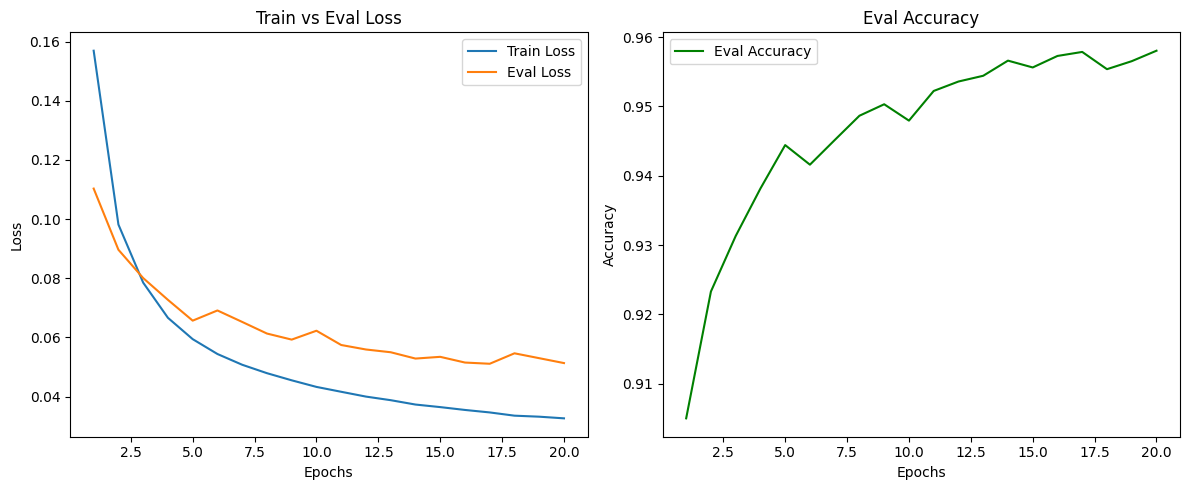

In [22]:
def plot_metrics(train_losses, eval_losses, eval_accuracies):
    """
    Crea un grafico delle metriche salvate.

    Args:
        train_losses (List[float]): Lista dei loss del training.
        eval_losses (List[float]): Lista dei loss di valutazione.
        eval_accuracies (List[float]): Lista delle accuratezze di valutazione.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot del train loss e eval loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, eval_losses, label="Eval Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train vs Eval Loss")
    plt.legend()

    # Plot dell'eval accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, eval_accuracies, label="Eval Accuracy", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Eval Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, eval_losses, eval_accuracies)

## 7. Rank-1, Rank-5, Rank-10 & mAP(%)

* **rank-K**: Misura se il vero match (cioè l'immagine dello stesso veicolo, con lo stesso vehicle-id) è nei primi K risultati restituiti dal modello.

* **mAP** (Mean Average Precision): Valuta quanto bene il modello classifica l'intera lista dei risultati, tenendo conto sia della precisione che del posizionamento dei match corretti nella classifica

In [23]:
import matplotlib.pyplot as plt
import random
import torch
import torchvision.transforms as transforms
import numpy as np
from PIL import Image

def preprocess_image(image_path, device):
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0).to(device)

def feature_extractor(model, image_path, device):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        image_tensor = preprocess_image(image_path, device)
        features = model.forward_once(image_tensor)
    return features.cpu().numpy().flatten()

def mean_average_precision(results):
    average_precisions = []
    for query_id, sorted_vehicle_ids in results:
        relevant = [1 if vid == query_id else 0 for vid in sorted_vehicle_ids]
        if sum(relevant) == 0:
            continue
        precisions = []
        num_relevant = 0
        for i, rel in enumerate(relevant):
            if rel:
                num_relevant += 1
                precisions.append(num_relevant / (i + 1))
        average_precisions.append(sum(precisions) / sum(relevant))
    return np.mean(average_precisions) if average_precisions else 0

def rank_evaluation(model, dataframe, top_k=10, num_examples=3, device="cuda"):
    model = model.to(device)
    model.eval()
    
    image_paths = dataframe["image_name"].apply(lambda x: f"./data/VeRi/image_test/{x}")
    image_features = {path: feature_extractor(model, path, device) for path in image_paths}
    image_feature_matrix = np.array(list(image_features.values()))
    image_names = list(image_features.keys())
    
    image_to_vehicle = {row["image_name"]: row["vehicle_id"] for _, row in dataframe.iterrows()}
    
    correct_rank1 = 0
    correct_rank5 = 0
    correct_rank10 = 0
    all_results = []
    map_results = []
    
    for query_img in image_names:
        query_feature = image_features[query_img].reshape(1, -1)
        query_id = image_to_vehicle[query_img.split("/")[-1]]
        
        dists = np.linalg.norm(image_feature_matrix - query_feature, axis=1)
        sorted_indices = np.argsort(dists)
        sorted_images = [image_names[i] for i in sorted_indices if image_names[i] != query_img]
        sorted_vehicle_ids = [image_to_vehicle[img.split("/")[-1]] for img in sorted_images]
        sorted_distances = dists[sorted_indices][1:top_k+1]
        
        if query_id == sorted_vehicle_ids[0]:
            correct_rank1 += 1
        if query_id in sorted_vehicle_ids[:5]:
            correct_rank5 += 1
        if query_id in sorted_vehicle_ids[:10]:
            correct_rank10 += 1
        
        map_results.append((query_id, sorted_vehicle_ids))
        all_results.append((query_img, query_id, sorted_images[:top_k], sorted_vehicle_ids[:top_k], sorted_distances))
    
    rank1_accuracy = correct_rank1 / len(dataframe)
    rank5_accuracy = correct_rank5 / len(dataframe)
    rank10_accuracy = correct_rank10 / len(dataframe)
    map_score = mean_average_precision(map_results)
    
    print(f"Rank-1 Accuracy: {rank1_accuracy:.2%}")
    print(f"Rank-5 Accuracy: {rank5_accuracy:.2%}")
    print(f"Rank-10 Accuracy: {rank10_accuracy:.2%}")
    print(f"mAP: {map_score:.2%}")
    
    num_examples = min(num_examples, len(all_results))
    for example in random.sample(all_results, num_examples):
        query_img, query_id, top_matches, top_ids, distances = example
        fig, axes = plt.subplots(1, top_k + 1, figsize=(20, 5))
        
        query_image = plt.imread(query_img)
        axes[0].imshow(query_image)
        axes[0].set_title(f"Query (ID: {query_id})")
        axes[0].axis("off")
        
        for i, (img, vehicle_id, dist) in enumerate(zip(top_matches, top_ids, distances)):
            result_img = plt.imread(img)
            axes[i + 1].imshow(result_img)
            axes[i + 1].set_title(f"ID: {vehicle_id}\nDist: {dist:.4f}")
            axes[i + 1].axis("off")
        
        plt.show()
    
    return rank1_accuracy, rank5_accuracy, rank10_accuracy, map_score

Rank-1 Accuracy: 73.69%
Rank-5 Accuracy: 90.93%
Rank-10 Accuracy: 94.92%
mAP: 25.09%


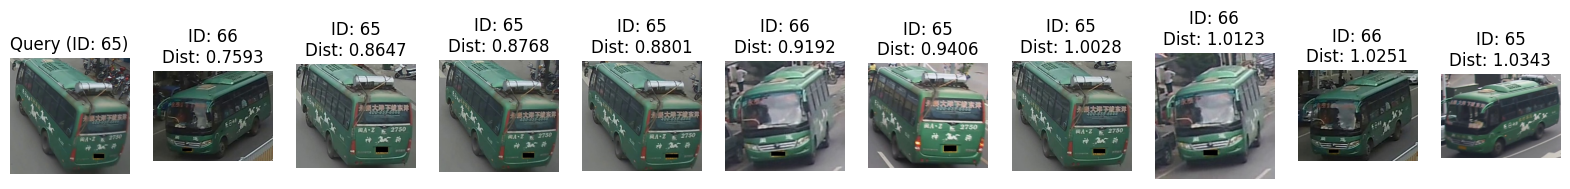

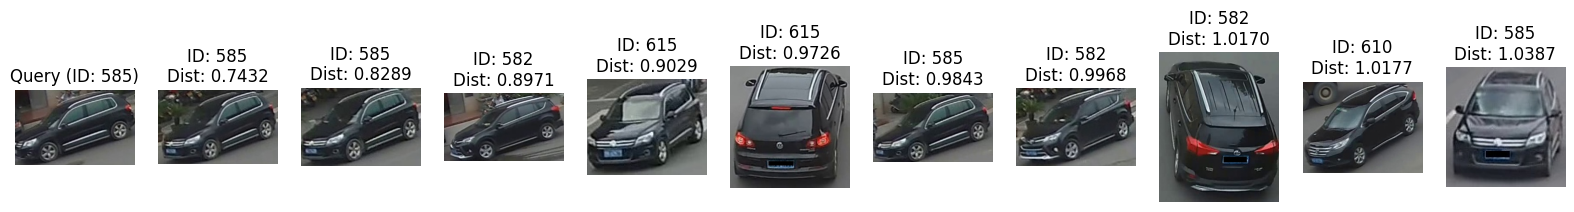

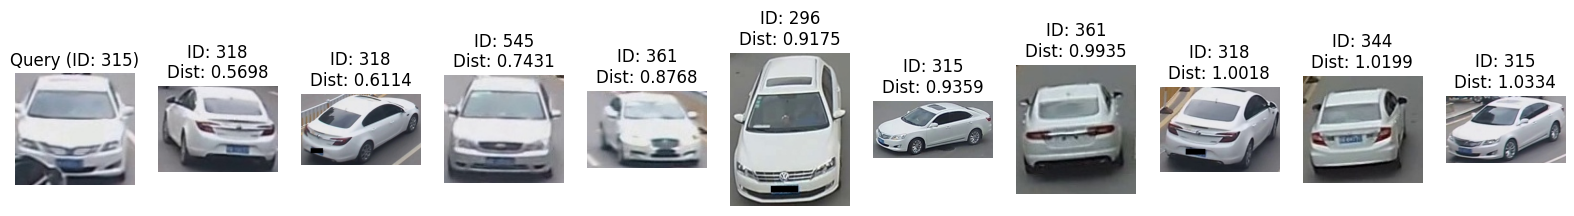

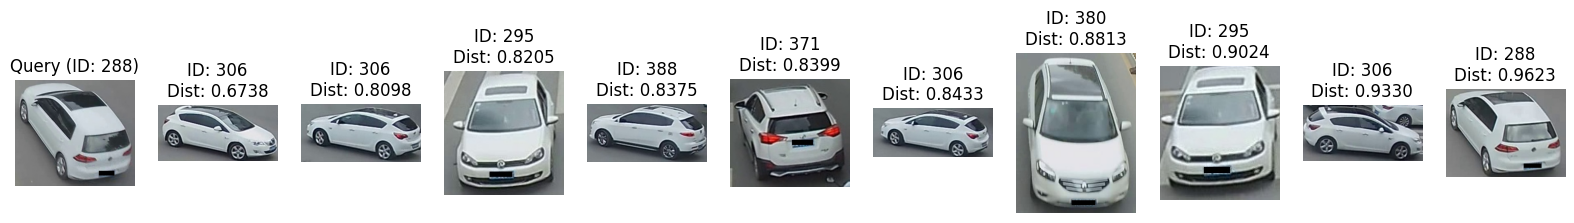

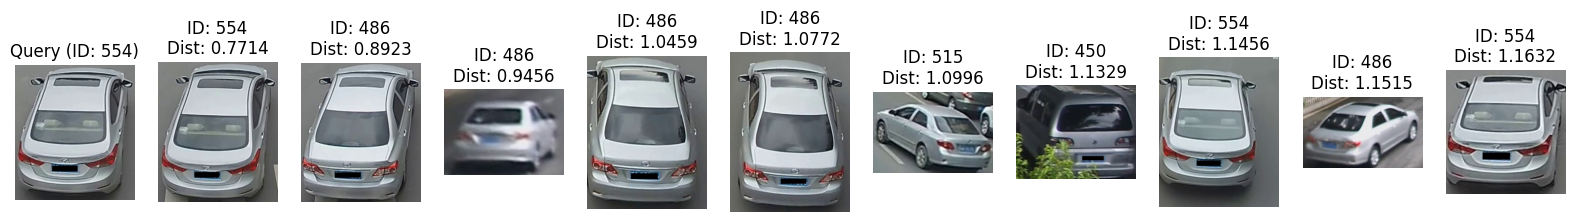

(0.7369375593747302,
 0.9093185940063909,
 0.9492184126435789,
 np.float64(0.2509084786394587))

In [ ]:
rank_evaluation(model, test_labels_df, top_k=10, num_examples=5)

## 8. Tests

In [25]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F

def find_and_visualize_best_match(query_image_path, reference_image_paths, model, transform, device="cpu"):
    """
    Trova l'immagine più simile a una query e visualizza tutte le immagini di riferimento,
    colorando di verde l'immagine più simile.

    Args:
        query_image_path (str): Percorso dell'immagine di query.
        reference_image_paths (list): Lista di percorsi delle immagini di riferimento.
        model (torch.nn.Module): Modello Siamese addestrato.
        transform (callable): Trasformazioni per preprocessare le immagini.
        device (str): Dispositivo per l'elaborazione ('cpu' o 'cuda').

    Returns:
        tuple: (Percorso dell'immagine più simile, distanza minima).
    """
    # Preprocessa l'immagine di query
    query_image = Image.open(query_image_path).convert("RGB")
    query_tensor = transform(query_image).unsqueeze(0).to(device)

    # Inizializza la ricerca
    distances = []

    # Confronta l'immagine di query con ogni immagine di riferimento
    model.eval()
    for ref_path in reference_image_paths:
        ref_image = Image.open(ref_path).convert("RGB")
        ref_tensor = transform(ref_image).unsqueeze(0).to(device)

        with torch.no_grad():
            # Calcola gli embedding usando il forward completo
            query_embedding, ref_embedding = model(query_tensor, ref_tensor)

        # Calcola la distanza tra gli embedding
        distance = F.pairwise_distance(query_embedding, ref_embedding).item()
        distances.append((ref_path, ref_image, distance))

    # Ordina per distanza crescente
    distances.sort(key=lambda x: x[2])
    most_similar_path, most_similar_image, min_distance = distances[0]

    # Visualizzazione
    fig, axes = plt.subplots(1, len(reference_image_paths) + 1, figsize=(15, 5))

    # Immagine di query
    axes[0].imshow(query_image)
    axes[0].axis("off")
    axes[0].set_title("Query Image")

    # Visualizza immagini di riferimento
    for idx, (ref_path, ref_image, distance) in enumerate(distances, start=1):
        axes[idx].imshow(ref_image)
        axes[idx].axis("off")

        # Colore della cornice
        color = "green" if ref_path == most_similar_path else "red"
        axes[idx].set_title(f"Dist: {distance:.4f}", color=color)

    plt.tight_layout()
    plt.show()

    return most_similar_path, min_distance

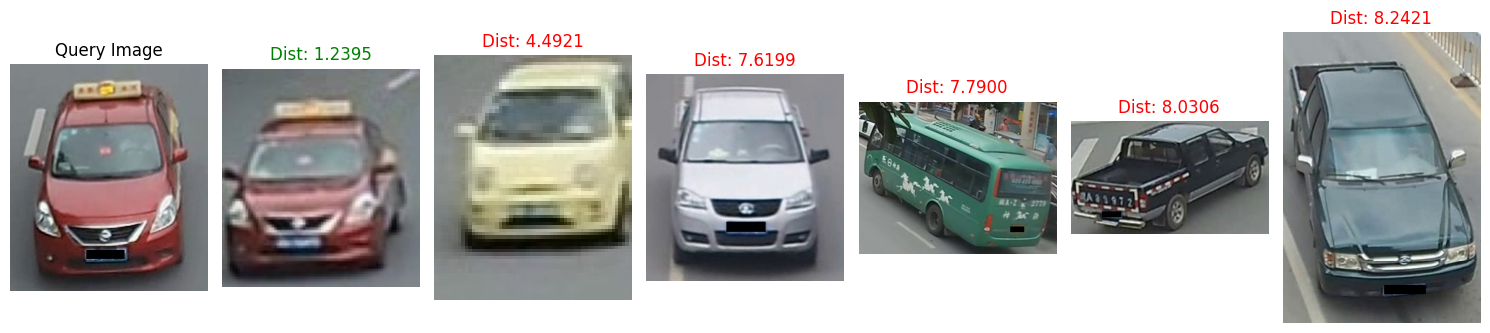

L'immagine più simile è: ./data/VeRi/image_test/0035_c006_00001085_1.jpg con una distanza di: 1.2395


In [26]:
# Percorsi
query_image = "./data/VeRi/image_query/0035_c006_00001150_0.jpg"
reference_images = ["./data/VeRi/image_test/0002_c006_00083490_0.jpg",
                    "./data/VeRi/image_test/0066_c016_00055465_0.jpg",
                    "./data/VeRi/image_test/0035_c006_00001085_1.jpg",
                    "./data/VeRi/image_test/0086_c013_00079890_0.jpg",
                    "./data/VeRi/image_test/0102_c016_00010770_0.jpg",
                    "./data/VeRi/image_test/0101_c001_00043710_0.jpg"]

# Dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# Esegui la ricerca
most_similar_image, distance = find_and_visualize_best_match(query_image, reference_images, model, test_transform, device)

# Risultato
print(f"L'immagine più simile è: {most_similar_image} con una distanza di: {distance:.4f}")

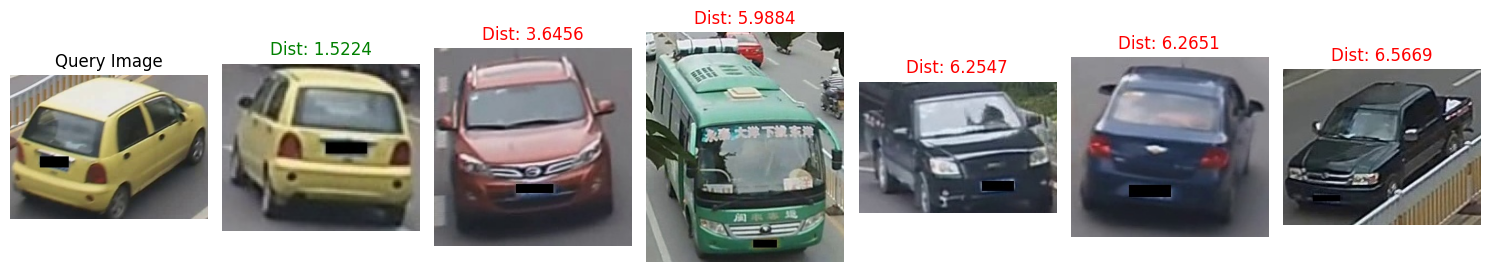

L'immagine più simile è: ./data/VeRi/image_test/0002_c002_00030670_0.jpg con una distanza di: 1.5224


In [27]:
# Percorsi
query_image = "./data/VeRi/image_query/0002_c002_00030600_0.jpg"
reference_images = ["./data/VeRi/image_test/0102_c012_00007875_0.jpg",
                    "./data/VeRi/image_test/0002_c002_00030670_0.jpg",
                    "./data/VeRi/image_test/0006_c019_00024125_0.jpg",
                    "./data/VeRi/image_test/0090_c009_00078235_0.jpg",
                    "./data/VeRi/image_test/0042_c002_00085830_0.jpg",
                    "./data/VeRi/image_test/0065_c016_00068360_0.jpg"]

# Dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# Esegui la ricerca
most_similar_image, distance = find_and_visualize_best_match(query_image, reference_images, model, test_transform, device)

# Risultato
print(f"L'immagine più simile è: {most_similar_image} con una distanza di: {distance:.4f}")


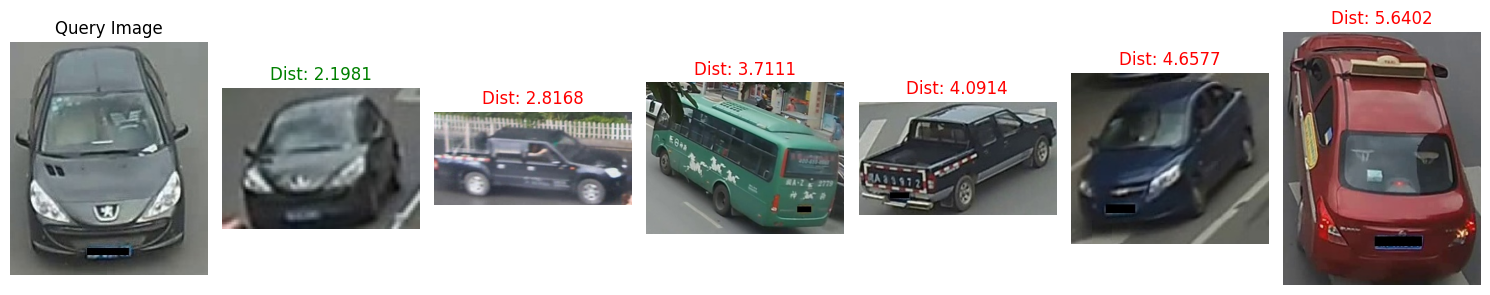

L'immagine più simile è: ./data/VeRi/image_test/0063_c017_00008655_1.jpg
con una distanza di: 2.1981


In [28]:
query_image = "./data/VeRi/image_query/0063_c001_00009565_0.jpg"
reference_images = ["./data/VeRi/image_test/0042_c017_00082800_0.jpg",
                    "./data/VeRi/image_test/0066_c016_00055465_0.jpg",
                    "./data/VeRi/image_test/0035_c003_00001855_0.jpg",
                    "./data/VeRi/image_test/0063_c017_00008655_1.jpg",
                    "./data/VeRi/image_test/0096_c007_00030635_0.jpg",
                    "./data/VeRi/image_test/0101_c001_00043710_0.jpg"]

# Dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# Esegui la ricerca
most_similar_image, distance = find_and_visualize_best_match(query_image, reference_images, model, test_transform, device)

# Risultato
print(f"L'immagine più simile è: {most_similar_image}\ncon una distanza di: {distance:.4f}")